<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
<string>:7: FutureWarning: 'Y' is deprecated and will be

Monthly flood threshold (95th percentile): 425.72 mm


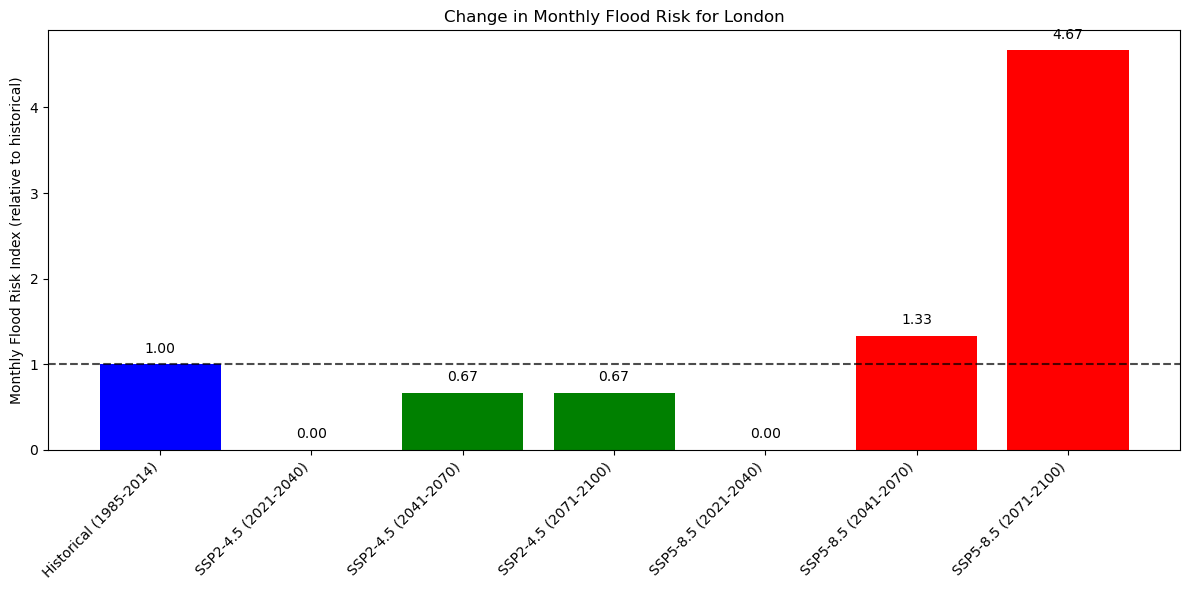


Detailed Monthly Flood Risk Results:
Historical (1985-2014): 1.00x baseline risk
SSP2-4.5 (2021-2040): 0.00x baseline risk
SSP2-4.5 (2041-2070): 0.67x baseline risk
SSP2-4.5 (2071-2100): 0.67x baseline risk
SSP5-8.5 (2021-2040): 0.00x baseline risk
SSP5-8.5 (2041-2070): 1.33x baseline risk
SSP5-8.5 (2071-2100): 4.67x baseline risk


In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
from matplotlib.colors import ListedColormap
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns

# Load the NetCDF files
def load_data():
    # Historical data
    hist_precip = xr.open_dataset('datasets/cmip6_pr_historical_UKESM1-0-LL.nc')
    
    # Future scenarios
    ssp245_precip = xr.open_dataset('datasets/cmip6_pr_ssp245_UKESM1-0-LL.nc')
    ssp585_precip = xr.open_dataset('datasets/cmip6_pr_ssp585_UKESM1-0-LL.nc')
    
    return hist_precip, ssp245_precip, ssp585_precip

# Extract data for London (approximate coordinates)
def extract_london_data(dataset):
    # London coordinates (approximate)
    lon_london = -0.1278
    lat_london = 51.5074
    
    # Find nearest grid point
    london_data = dataset.sel(lon=lon_london, lat=lat_london, method='nearest')
    return london_data

# Calculate extreme precipitation metrics for monthly data
def calculate_monthly_extremes(dataset):
    # Convert from kg/m^2/s to mm/month if needed
    if dataset.pr.units in ['kg m-2 s-1', 'kg/m2/s']:
        # Average seconds in a month: ~2,628,000
        precip_monthly = dataset.pr * 2628000
    else:
        precip_monthly = dataset.pr
    
    # Calculate metrics
    # 1. Annual maximum monthly precipitation
    annual_max = precip_monthly.resample(time='Y').max()
    
    # 2. Number of months with precipitation > 100mm (adjust threshold as appropriate)
    heavy_rain_months = (precip_monthly > 100).resample(time='Y').sum()
    
    # 3. 3-month cumulative maximum precipitation (for seasonal flooding)
    rolling_3m = precip_monthly.rolling(time=3).sum()
    annual_max_3month = rolling_3m.resample(time='Y').max()
    
    return {
        'annual_max': annual_max,
        'heavy_rain_months': heavy_rain_months,
        'annual_max_3month': annual_max_3month
    }

# Modified flood risk indicator for monthly data
def calculate_monthly_flood_risk_indicator(hist_data, ssp245_data, ssp585_data):
    # Define periods
    hist_period = slice('1985', '2014')
    future_periods = [slice('2021', '2040'), slice('2041', '2070'), slice('2071', '2100')]
    period_names = ['2021-2040', '2041-2070', '2071-2100']
    
    # Calculate historical threshold for flooding (95th percentile of 3-month precipitation)
    hist_3month = hist_data['annual_max_3month'].sel(time=hist_period)
    flood_threshold = np.percentile(hist_3month, 95)
    
    # Calculate how often this threshold is exceeded in future periods
    results = {'Historical (1985-2014)': 1.0}  # Baseline
    
    # SSP2-4.5
    for period, name in zip(future_periods, period_names):
        future_3month = ssp245_data['annual_max_3month'].sel(time=period)
        exceed_prob = (future_3month > flood_threshold).mean()
        results[f'SSP2-4.5 ({name})'] = float(exceed_prob) / 0.05  # Normalized to historical
    
    # SSP5-8.5
    for period, name in zip(future_periods, period_names):
        future_3month = ssp585_data['annual_max_3month'].sel(time=period)
        exceed_prob = (future_3month > flood_threshold).mean()
        results[f'SSP5-8.5 ({name})'] = float(exceed_prob) / 0.05  # Normalized to historical
    
    return results, flood_threshold

def plot_monthly_flood_risk_change(flood_risk_dict):
    scenarios = list(flood_risk_dict.keys())
    values = list(flood_risk_dict.values())
    
    plt.figure(figsize=(12, 6))
    bars = plt.bar(scenarios, values, color=['blue'] + ['green']*3 + ['red']*3)
    
    # Add horizontal line at baseline
    plt.axhline(y=1, color='black', linestyle='--', alpha=0.7)
    
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Monthly Flood Risk Index (relative to historical)')
    plt.title('Change in Monthly Flood Risk for London')
    
    # Add values on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                 f'{height:.2f}', ha='center', va='bottom')
    
    plt.tight_layout()
    return plt.gcf()

# Function to run the complete analysis
def run_monthly_flood_risk_analysis():
    # Load data
    hist_precip, ssp245_precip, ssp585_precip = load_data()
    
    # Extract London data
    hist_london = extract_london_data(hist_precip)
    ssp245_london = extract_london_data(ssp245_precip)
    ssp585_london = extract_london_data(ssp585_precip)
    
    # Calculate extremes
    hist_extremes = calculate_monthly_extremes(hist_london)
    ssp245_extremes = calculate_monthly_extremes(ssp245_london)
    ssp585_extremes = calculate_monthly_extremes(ssp585_london)
    
    # Calculate flood risk
    flood_risk, threshold = calculate_monthly_flood_risk_indicator(
        hist_extremes, ssp245_extremes, ssp585_extremes
    )
    
    # Print the flood threshold value
    print(f"Monthly flood threshold (95th percentile): {threshold:.2f} mm")
    
    # Plot the results
    fig = plot_monthly_flood_risk_change(flood_risk)
    plt.savefig('figures/london_monthly_flood_risk.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Return the calculated results
    return flood_risk, threshold

# Execute the analysis
if __name__ == "__main__":
    flood_risk, threshold = run_monthly_flood_risk_analysis()
    
    # Print the detailed results
    print("\nDetailed Monthly Flood Risk Results:")
    for scenario, value in flood_risk.items():
        print(f"{scenario}: {value:.2f}x baseline risk")